# Data_Loading_Cleaning 

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 100)
pd.set_option("display.width", 140)


In [2]:
df = pd.read_excel("Online Retail.xlsx")
df.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [3]:
df.shape
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [4]:
df.columns = (
    df.columns
      .str.strip()
      .str.lower()
      .str.replace(" ", "_")
)
df.columns


Index(['invoiceno', 'stockcode', 'description', 'quantity', 'invoicedate', 'unitprice', 'customerid', 'country'], dtype='object')

In [5]:
df["invoicedate"] = pd.to_datetime(df["invoicedate"])


In [6]:
df["revenue"] = df["quantity"] * df["unitprice"]
# REVENUE CALCULATION

In [7]:
returns_df = df[df["quantity"] < 0]
sales_df = df[df["quantity"] > 0]
# RETURNS

In [8]:
returns_df.shape, sales_df.shape
# Negative quantities represent returned or cancelled transactions

((10624, 9), (531285, 9))

In [10]:
sales_df = sales_df.dropna(subset=["customerid"])
# Transactions without customer identifiers cannot be used for customer-level analysis

In [11]:
sales_df = sales_df[
    (sales_df["quantity"] > 0) &
    (sales_df["unitprice"] > 0)
]


In [12]:
sales_df.describe()


,quantity,invoicedate,unitprice,customerid,revenue
count,397884.000000,397884,397884.000000,397884.000000,397884.000000
mean,12.988238,2011-07-10 23:41:23.511023360,3.116488,15294.423453,22.397000
min,1.000000,2010-12-01 08:26:00,0.001000,12346.000000,0.001000
25%,2.000000,2011-04-07 11:12:00,1.250000,13969.000000,4.680000
50%,6.000000,2011-07-31 14:39:00,1.950000,15159.000000,11.800000
75%,12.000000,2011-10-20 14:33:00,3.750000,16795.000000,19.800000
max,80995.000000,2011-12-09 12:50:00,8142.750000,18287.000000,168469.600000
std,179.331775,NaN,22.097877,1713.141560,309.071041


In [14]:
sales_df.isna().sum()


invoiceno      0
stockcode      0
description    0
quantity       0
invoicedate    0
unitprice      0
customerid     0
country        0
revenue        0
dtype: int64

In [15]:
sales_df["customerid"] = sales_df["customerid"].astype(int)


# Sales Performance Analysis

In [17]:
sales_df["year"] = sales_df["invoicedate"].dt.year
sales_df["month"] = sales_df["invoicedate"].dt.to_period("M")


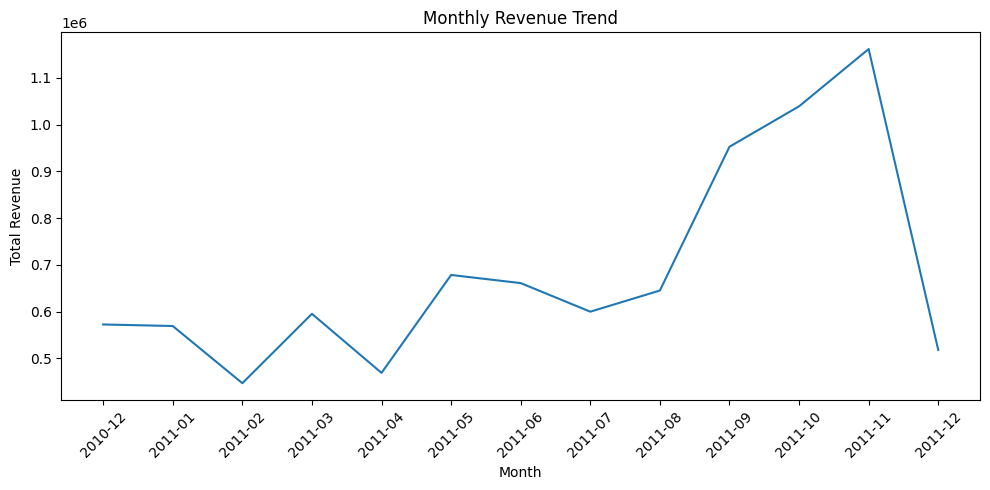

In [18]:
monthly_revenue = (
    sales_df
    .groupby("month", as_index=False)["revenue"]
    .sum()
)

plt.figure(figsize=(10,5))
plt.plot(monthly_revenue["month"].astype(str), monthly_revenue["revenue"])
plt.xticks(rotation=45)
plt.xlabel("Month")
plt.ylabel("Total Revenue")
plt.title("Monthly Revenue Trend")
plt.tight_layout()
plt.show()


In [23]:
country_revenue = (
    sales_df
    .groupby("country", as_index=False)["revenue"]
    .sum()
    .sort_values("revenue", ascending=False)
)

country_revenue.head()


,country,revenue
35,United Kingdom,7308391.554
23,Netherlands,285446.340
10,EIRE,265545.900
14,Germany,228867.140
13,France,209024.050


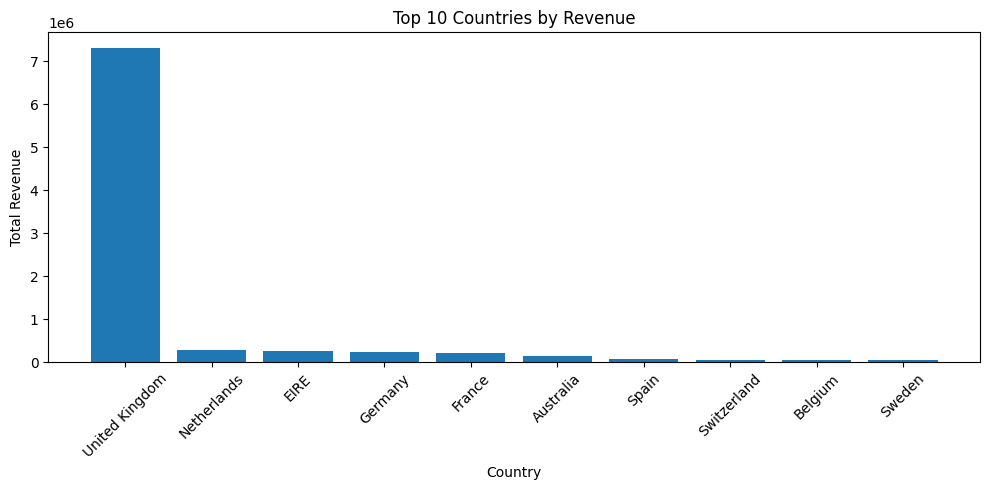

In [20]:
top_countries = country_revenue.head(10)

plt.figure(figsize=(10,5))
plt.bar(top_countries["country"], top_countries["revenue"])
plt.xticks(rotation=45)
plt.xlabel("Country")
plt.ylabel("Total Revenue")
plt.title("Top 10 Countries by Revenue")
plt.tight_layout()
plt.show()


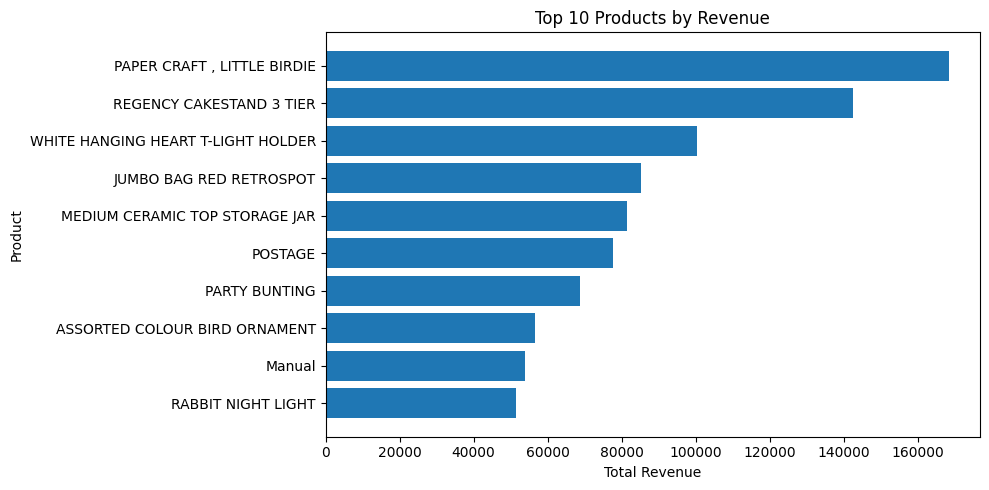

In [24]:
product_revenue = (
    sales_df
    .groupby("description", as_index=False)["revenue"]
    .sum()
    .sort_values("revenue", ascending=False)
)

top_products = product_revenue.head(10)

plt.figure(figsize=(10,5))
plt.barh(top_products["description"], top_products["revenue"])
plt.xlabel("Total Revenue")
plt.ylabel("Product")
plt.title("Top 10 Products by Revenue")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [25]:
top_20_share = (
    product_revenue.head(20)["revenue"].sum() /
    product_revenue["revenue"].sum()
)

top_20_share


np.float64(0.1417694985584626)

# Customer Segmentation (RFM Analysis)

In [26]:
snapshot_date = sales_df["invoicedate"].max() + pd.Timedelta(days=1)
snapshot_date
# We define a snapshot date to consistently calculate recency for all customers

Timestamp('2011-12-10 12:50:00')

In [27]:
rfm = (
    sales_df
    .groupby("customerid")
    .agg({
        "invoicedate": lambda x: (snapshot_date - x.max()).days,  # Recency
        "invoiceno": "nunique",                                   # Frequency
        "revenue": "sum"                                          # Monetary
    })
    .reset_index()
)

rfm.columns = ["customerid", "recency", "frequency", "monetary"]
rfm.head()


,customerid,recency,frequency,monetary
0,12346,326,1,77183.60
1,12347,2,7,4310.00
2,12348,75,4,1797.24
3,12349,19,1,1757.55
4,12350,310,1,334.40


#### Recency: days since last purchase
#### Frequency: number of invoices
#### Monetary: total revenue

In [29]:
rfm["r_score"] = pd.qcut(rfm["recency"], 5, labels=[5,4,3,2,1])
rfm["f_score"] = pd.qcut(rfm["frequency"].rank(method="first"), 5, labels=[1,2,3,4,5])
rfm["m_score"] = pd.qcut(rfm["monetary"], 5, labels=[1,2,3,4,5])

rfm.head()

,customerid,recency,frequency,monetary,r_score,f_score,m_score
0,12346,326,1,77183.60,1,1,5
1,12347,2,7,4310.00,5,5,5
2,12348,75,4,1797.24,2,4,4
3,12349,19,1,1757.55,4,1,4
4,12350,310,1,334.40,1,1,2


In [30]:
rfm["rfm_segment"] = rfm["r_score"].astype(str) + rfm["f_score"].astype(str) + rfm["m_score"].astype(str)


In [32]:
rfm["r_score"] = rfm["r_score"].astype(int)
rfm["f_score"] = rfm["f_score"].astype(int)
rfm["m_score"] = rfm["m_score"].astype(int)


In [34]:
def segment_customer(row):
    if row["r_score"] >= 4 and row["f_score"] >= 4 and row["m_score"] >= 4:
        return "Champions"
    elif row["r_score"] >= 3 and row["f_score"] >= 3:
        return "Loyal Customers"
    elif row["r_score"] <= 2 and row["f_score"] >= 3:
        return "At Risk"
    elif row["r_score"] <= 2 and row["f_score"] <= 2:
        return "Lost Customers"
    else:
        return "Potential Loyalists"


In [35]:
rfm["segment"] = rfm.apply(segment_customer, axis=1)
rfm.head()


,customerid,recency,frequency,monetary,r_score,f_score,m_score,rfm_segment,segment
0,12346,326,1,77183.60,1,1,5,115,Lost Customers
1,12347,2,7,4310.00,5,5,5,555,Champions
2,12348,75,4,1797.24,2,4,4,244,At Risk
3,12349,19,1,1757.55,4,1,4,414,Potential Loyalists
4,12350,310,1,334.40,1,1,2,112,Lost Customers


In [36]:
rfm[["r_score", "f_score", "m_score"]].dtypes


r_score    int64
f_score    int64
m_score    int64
dtype: object

In [41]:
segment_summary = (
    rfm["segment"]
    .value_counts()
    .to_frame(name="Customer Count")
)

segment_summary["Share (%)"] = (
    segment_summary["Customer Count"] / segment_summary["Customer Count"].sum() * 100
).round(2)

segment_summary


,Customer Count,Share (%)
segment,,
Lost Customers,1065,24.55
Loyal Customers,998,23.01
Champions,962,22.18
Potential Loyalists,670,15.44
At Risk,643,14.82


In [43]:
segment_revenue = (
    rfm
    .groupby("segment")["monetary"]
    .sum()
    .sort_values(ascending=False)
)

segment_revenue
# Although customer segments are similar in size, their revenue contributions differ significantly

segment
Champions              5809341.070
Loyal Customers        1474127.551
At Risk                 800531.551
Lost Customers          519408.572
Potential Loyalists     307999.160
Name: monetary, dtype: float64

In [44]:
segment_revenue_share = (
    segment_revenue / segment_revenue.sum() * 100
).round(2)

segment_revenue_share


segment
Champions              65.19
Loyal Customers        16.54
At Risk                 8.98
Lost Customers          5.83
Potential Loyalists     3.46
Name: monetary, dtype: float64

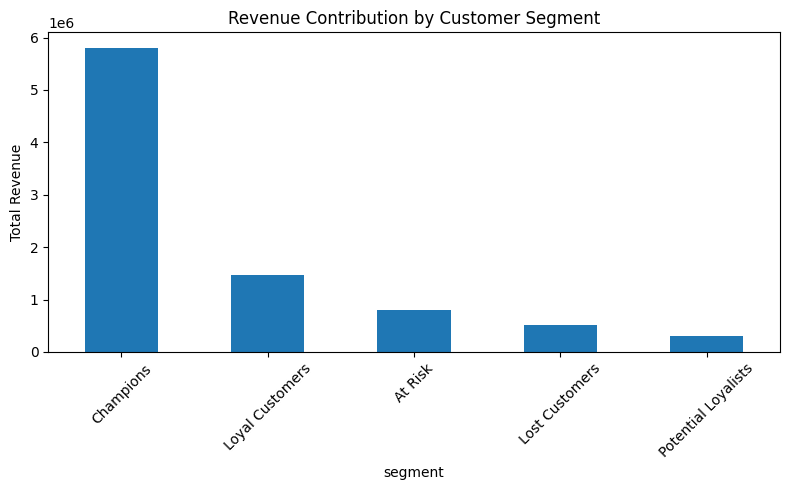

In [47]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
segment_revenue.plot(kind="bar")
plt.ylabel("Total Revenue")
plt.title("Revenue Contribution by Customer Segment")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# A relatively small group of customers generates a disproportionately large share of total revenue.

In [48]:
segment_rfm_means = (
    rfm
    .groupby("segment")[["recency", "frequency", "monetary"]]
    .mean()
    .round(1)
)

segment_rfm_means


,recency,frequency,monetary
segment,,,
At Risk,152.8,3.4,1245.0
Champions,12.9,11.1,6038.8
Lost Customers,217.9,1.1,487.7
Loyal Customers,34.1,3.7,1477.1
Potential Loyalists,36.8,1.2,459.7


# 4.1 Executive Summary

This project analyzes transaction-level e-commerce data to evaluate sales performance and customer behavior.
Using Exploratory Data Analysis (EDA) and RFM-based customer segmentation, we identify key revenue drivers and actionable customer segments.

A major finding of the analysis is that revenue is highly concentrated within a relatively small group of customers, while customer counts across segments are fairly balanced. This highlights the importance of targeted retention and segmentation-driven decision-making.

# 4.2 Key Insights from Exploratory Data Analysis

## Sales Trend:

Monthly revenue shows a general upward trend throughout 2011.

A noticeable decline in December is observed, which may be related to incomplete data coverage for the final month.

## Geographical Distribution:

The United Kingdom is the dominant revenue-generating country, which is consistent with the retailer being UK-based.

Other countries contribute smaller but diverse revenue shares, indicating international reach with lower intensity.

## Product Revenue Concentration:

The top 20 products account for only ~14.2% of total revenue.

This indicates that revenue is not driven by a small number of products, but rather by customer purchasing behavior.

### Insight: Revenue performance is more strongly influenced by customer behavior than by product concentration.

# 4.3 Customer Segmentation Overview (RFM)

Customers were segmented using Recency, Frequency, and Monetary (RFM) metrics.
The distribution of customers across segments is relatively balanced:

## Lost Customers: 24.55%

## Loyal Customers: 23.01%

## Champions: 22.18%

## Potential Loyalists: 15.44%

## At Risk: 14.82%

Despite this balanced distribution, the revenue contribution across segments varies significantly.

# 4.4 Revenue Contribution by Customer Segment

The revenue analysis reveals a strong imbalance between customer count and value contribution:

## Champions generate ~65.2% of total revenue while representing only ~22% of customers.

## Loyal Customers contribute ~16.5% of revenue.

The remaining three segments combined generate less than 20% of total revenue.

Key Insight:
A relatively small group of customers generates a disproportionately large share of total revenue.

## 4.5 Segment Profiles Based on RFM Averages

Champions

Very recent purchases

High purchase frequency

Highest monetary value

Loyal Customers

Moderate recency

Consistent purchase behavior

Strong revenue contribution

At Risk Customers

Long time since last purchase

Previously frequent buyers

Medium-to-high monetary value

Potential Loyalists

Recent but infrequent purchases

Low monetary value so far

Lost Customers

Very low recency and frequency

Minimal revenue contribution

These patterns validate the effectiveness of the RFM segmentation approach.

## 4.6 Business Recommendations

Champions

Prioritize retention through personalized offers and VIP benefits.

Focus on upselling and cross-selling strategies.

Loyal Customers

Strengthen loyalty programs to increase purchase frequency.

Encourage progression toward the Champions segment.

At Risk Customers

Implement win-back campaigns targeting customers who were previously valuable.

Time-sensitive incentives may help reactivation.

Potential Loyalists

Encourage repeat purchases with first-repeat discounts or free shipping offers.

Lost Customers

Limit marketing spend and focus on low-cost re-engagement strategies.

Strategic Focus:
Marketing resources should prioritize Champions retention and At Risk recovery, as these segments offer the highest revenue leverage.

## 4.7 Limitations

Profit and cost data were not available; analysis is based solely on revenue.

The dataset covers a limited time period (2010–2011).

December sales data may be incomplete, affecting monthly trend interpretation.

## 4.8 Conclusion

This analysis demonstrates that customer-level segmentation provides significantly deeper insights than aggregate sales analysis alone.
By applying RFM analysis to real-world transaction data, we identified clear differences in customer value and behavior.

The findings emphasize that retaining high-value customers and proactively managing at-risk segments is critical for maximizing long-term business performance.